In [1]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.interpolate as interp
import re
import joblib
import time

In [2]:
from multioutput_functions import *

In [3]:
singles = pd.read_hdf(r'C:/Users/juand/Research/h5_files/single_spectra_with_synthphot.h5')
singles.columns
singles = singles.drop(['OPT_SPT','NIR_SPT','LIT_SPT', 'DATA_REFERENCE',
       'MKO_J', 'MKO_H', 'MKO_KS', '2MASS_J', '2MASS_H', '2MASS_KS',
       'MKO_J_ER', 'MKO_H_ER', 'MKO_KS_ER', '2MASS_J_ER', '2MASS_H_ER',
       '2MASS_KS_ER','SPEX_SPT','NAME','DESIGNATION'],axis=1)
# fig, axe = plt.subplots()
# axe.hist(singles['CLASS'],bins=23)
singles = singles.dropna()
singles = singles.loc[singles['CLASS']=='___']
singles = singles.reset_index(drop=True)
val = singles['CLEAN'][0]
list(singles['CLEAN']).count(val)- len(singles)
singles = singles.loc[singles['CLEAN']==val]
singles = singles.reset_index(drop=True)
singles = singles.drop(['CLEAN','CLASS'],axis=1)
singles

,FLUX,UNCERTAINTY,J_SNR,SPT,WAVEGRID
0,"[1.703971008737426e-08, 1.7167767651926624e-08...","[2.946189681107825e-10, 2.839981860791596e-10,...",83.142639,M0.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
1,"[1.6583900940910237e-08, 1.672354310811135e-08...","[3.912149663373827e-11, 3.979055985709922e-11,...",581.457947,M0.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
2,"[1.7414131914668705e-08, 1.7907500376747947e-0...","[1.0127925267676249e-10, 1.1089358919449286e-1...",256.111267,M0.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
3,"[1.6936995662189027e-08, 1.674996727617314e-08...","[1.8588180209452355e-11, 1.8242771540848554e-1...",1258.298950,M0.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
4,"[1.0767825248909163e-08, 1.1080657969754826e-0...","[9.574767289704915e-11, 1.0068553068993794e-10...",151.937103,M1.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
...,...,...,...,...,...
1407,"[2.3139820970701434e-13, 1.246237555225135e-13...","[1.2961283330524777e-13, 1.2520460658453793e-1...",4.703918,T8.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
1408,"[5.244854443773445e-14, 6.580743947046151e-14,...","[3.029490952427518e-14, 2.968834229762724e-14,...",23.436972,T8.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
1409,"[-2.2614582467991454e-14, 5.872129739165835e-1...","[4.4876320743869606e-14, 4.616998222544605e-14...",13.918951,T8.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
1410,"[1.4678859815360097e-14, 1.7897430190283215e-1...","[6.009617385156795e-15, 6.170117985714561e-15,...",30.023281,T9.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."


In [4]:
standards = pd.read_hdf(r'C:/Users/juand/Research/h5_files/standards.h5')
waavv = standards["wavegrid"].iloc[0]

In [5]:
wave = singles['WAVEGRID'][0]
wavegrid_list=list(wave)
wave = np.array(wave)
wavegrid=wave

In [6]:
df = pd.read_hdf(r'C:/Users/juand/Research/h5_files/standards.h5')
STANDARDS = {
    "WAVE": df["wavegrid"].iloc[0],
    "SPT": df["sptype"],
    "FLUX": df["interpolated_flux"],
    "UNC": df["interpolated_noise"],
}

In [7]:
typenum=[]
for i in range(len(singles)):
    typenum.append(typeToNum(singles['SPT'][i]))
singles['SPT_NUM']=typenum
singles = singles.loc[singles['SPT_NUM']>15*np.ones(len(singles))]
singles = singles.reset_index(drop=True)
singles.head()

,FLUX,UNCERTAINTY,J_SNR,SPT,WAVEGRID,SPT_NUM
0,"[2.135159610671172e-10, 2.1796931627639386e-10...","[1.7590789550275392e-12, 1.7659007111735759e-1...",123.474426,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
1,"[1.9660627713093847e-10, 2.1131039893243844e-1...","[5.982245325049133e-12, 5.755711185801827e-12,...",94.018303,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
2,"[1.9950771920752281e-10, 2.079591490944689e-10...","[7.703832533018333e-13, 1.0951267822400711e-12...",386.537811,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
3,"[2.1571572208552167e-10, 2.211778834251868e-10...","[3.796086878369872e-13, 3.8170877535247325e-13...",912.152893,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
4,"[1.9762911463072993e-10, 2.0580528498234088e-1...","[2.2989224859548107e-12, 2.3022679333025286e-1...",204.598099,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0


In [8]:
newsnr=[]
for i in range(len(singles)):
    flux=singles['FLUX'][i]
    uncer=singles['UNCERTAINTY'][i]
    newsnr.append(measureSN(wave,flux,uncer))
singles['J_SNR']=newsnr
singles.head()

,FLUX,UNCERTAINTY,J_SNR,SPT,WAVEGRID,SPT_NUM
0,"[2.135159610671172e-10, 2.1796931627639386e-10...","[1.7590789550275392e-12, 1.7659007111735759e-1...",124.405599,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
1,"[1.9660627713093847e-10, 2.1131039893243844e-1...","[5.982245325049133e-12, 5.755711185801827e-12,...",100.726025,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
2,"[1.9950771920752281e-10, 2.079591490944689e-10...","[7.703832533018333e-13, 1.0951267822400711e-12...",381.343321,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
3,"[2.1571572208552167e-10, 2.211778834251868e-10...","[3.796086878369872e-13, 3.8170877535247325e-13...",925.724731,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0
4,"[1.9762911463072993e-10, 2.0580528498234088e-1...","[2.2989224859548107e-12, 2.3022679333025286e-1...",213.814198,M6.0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...",16.0


In [9]:
snrclass=[]
for i in range(len(singles)):
    snrQ = singles['J_SNR'][i]
    if snrQ<50:
        snrclass.append('low')
    elif (snrQ>=50)&(snrQ<100):
        snrclass.append('mid')
    else:
        snrclass.append('hig')
singles['SNR_CLASS']=snrclass

In [10]:
bina = pd.read_hdf(r'C:/Users/juand/Research/h5_files/spectral_templates_aug3_normalized.h5', key='binaries')
bina = bina.drop(['diff_'+str(i) for i in range(409)], axis=1)
binaries_wavegrid = pd.read_hdf(r'C:/Users/juand/Research/h5_files/spectral_templates_aug3_normalized.h5', key='wavegrid')
b_wavegrid = np.array(binaries_wavegrid)

In [11]:
interpol_flux=[]
for j in range(len(bina)):
    a=[]
    for i in range(409):
        a.append(bina["flux_" + str(i)][j])
    interpol_flux.append(a)
bina["interpol_flux"]=interpol_flux

bina = bina.loc[bina['primary_type']<=bina['secondary_type']]
bina = bina.reset_index(drop=True)

In [12]:
new_wave=wave
new_wave[-1]=b_wavegrid[-1]
fluxlist=[]
for i in range(len(bina)):
    fluxi=bina['interpol_flux'][i]
    nfluxi = interpolate_flux_wave(b_wavegrid, fluxi, wgrid=new_wave)
    fluxlist.append(nfluxi)
bina['FLUX']=fluxlist    

In [13]:
BINARIES = {
    "WAVE": wavegrid,
    "PRIM": bina["primary_type"],
    "SECO": bina["secondary_type"],
    "FLUX": bina["FLUX"],
}

In [14]:
def fast_binary_classify(wave,flux,unc,fit_range=[0.9, 2.4],standards=BINARIES,telluric=False,method="full"):
    if method == "kirkpatrick":
        fit_range = [0.9, 1.4]
    elif method == "full":
        fit_range = [0.9, 2.4]
    else:
        pass

    scales, chi = [], []
    weights = np.ones(len(wave))

    if telluric == True:
        msk = np.ones(len(weights))
        msk[
            np.where(
                np.logical_or(
                    np.logical_and(wavegrid > 1.35, wavegrid < 1.42),
                    np.logical_and(wavegrid > 1.8, wavegrid < 1.95),
                )
            )
        ] = 0
        weights = weights * msk

    # Loop through standards
    for std in standards["FLUX"]:
        if type(std)==list:
            std=np.array(std)
        scale = np.nansum(weights * (flux * std) / (unc**2)) / np.nansum(
            (weights * std**2) / (unc**2)
        )
        scales.append(scale)
        chisquared = np.nansum(
            weights * ((flux - (std * scales[-1])) ** 2) / (unc**2)
        )
        chi.append(chisquared)

    return standards["PRIM"][np.argmin(chi)], standards["SECO"][np.argmin(chi)], np.min(chi)

<AxesSubplot:xlabel='SPT_NUM', ylabel='SNR_CLASS'>

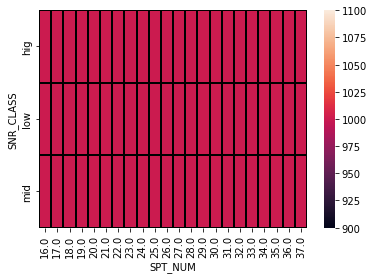

In [15]:
newdf = addstars(singles,1000, mintype='', maxtype=37)

spt_snr = newdf.groupby('SNR_CLASS').SPT_NUM.value_counts().unstack()
sns.heatmap(spt_snr,annot=False,linewidths=0.1,linecolor='black')

In [16]:
BinDF_low = binaryCreation(newdf,snr_range='low',target=40) #target=40
BinDF_mid = binaryCreation(newdf,snr_range='mid',target=40) #target=40
BinDF_hig = binaryCreation(newdf,snr_range='hig',target=40) #target=40
frames = [BinDF_low, BinDF_mid, BinDF_hig]
BinDF = pd.concat(frames)
BinDF = BinDF.reset_index(drop=True)
BinDF.head()

,system_interpolated_flux,system_interpolated_noise,primary_type,secondary_type,snr,SNR_CLASS,wavegrid
0,"[0.917556365316165, 0.8023411291940155, 0.8738...","[0.1596025765080506, 0.15991307380320072, 0.16...",16,16,7.808569,low,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
1,"[0.380740118930977, 0.09785631160145482, 0.194...","[0.1707711518854419, 0.23044747488941494, 0.17...",16,16,3.218501,low,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
2,"[0.7796329191435059, 1.1277256867673169, 0.749...","[0.16164514155838902, 0.16205548844786422, 0.1...",16,16,11.032378,low,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
3,"[0.6839373736816976, 0.7993670507716408, 0.707...","[0.05611569742396301, 0.06208040018085123, 0.0...",16,16,29.310885,low,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."
4,"[0.434268240128182, 0.8141686191431761, 0.8578...","[0.16965358473146977, 0.17005690824065298, 0.1...",16,16,13.236486,low,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ..."


In [17]:
len(BinDF)

30360

In [23]:
def traditionalMethod(starsdataframe: pd.DataFrame, target: int):
    dic_b = {'primary_type': [i for i in list(range(16,38)) for j in range(16,38)],
             'secondary_type': [i for j in range(16,38) for i in list(range(16,38))]}
    types_df = pd.DataFrame(dic_b)
    types_df = types_df.loc[types_df['primary_type']<=types_df['secondary_type']].reset_index(drop=True)
    types_count = types_df.groupby('secondary_type').primary_type.value_counts().unstack()
    pd_diffprim=types_count.copy()
    pd_diffseco=types_count.copy()
    pd_stdprim=types_count.copy()
    pd_stdseco=types_count.copy()

    rowslist=[]
    chilist = []

    for j in range(16,38):
        list1=[]
        list2=[]
        list3=[]
        list4=[]
        for l in range(16,j):
            list1.append(np.nan)
            list2.append(np.nan)
            list3.append(np.nan)
            list4.append(np.nan)
        for k in range(j,38):
            predsprim=[]
            predssec=[]
            realprim=[]
            realsec=[]
            diffprim=[]
            diffsec=[]
            reduced_df = starsdataframe[(starsdataframe['primary_type'] == j) & (starsdataframe['secondary_type'] == k)].reset_index()
            for i in range(0,target):
                rownumber = random.randint(0,len(reduced_df)-1)
                starindex = reduced_df['index'][rownumber]
                while starindex in rowslist:
                    rownumber = random.randint(0,len(reduced_df)-1)
                    starindex = reduced_df['index'][rownumber]
                rowslist.append(starindex)
                flux = reduced_df['system_interpolated_flux'][rownumber]
                unc = reduced_df['system_interpolated_noise'][rownumber]
                flux, unc = addNoise(flux, unc, scale=1.0)
                primreal = reduced_df['primary_type'][rownumber]
                secoreal = reduced_df['secondary_type'][rownumber]
                _bina_ = starsdataframe.drop(index=starindex).reset_index(drop=True)
                _BINARIES_ = {
                    "WAVE": wavegrid,
                    "PRIM": _bina_["primary_type"],
                    "SECO": _bina_["secondary_type"],
                    "FLUX": _bina_["system_interpolated_flux"],
                }
                prim_type, seco_type, chi = fast_binary_classify(wavegrid,flux,unc,standards=_BINARIES_)
                predsprim.append(prim_type)
                predssec.append(seco_type)
                realprim.append(primreal)
                realsec.append(secoreal)
                diffprim.append(prim_type-primreal)
                diffsec.append(seco_type-secoreal)
                chilist.append(chi)
            diffprim=np.array(diffprim)
            diffsec=np.array(diffsec)
            predsprim=np.array(predsprim)
            predssec=np.array(predssec)
            avg_diffprim=sum(diffprim)/len(diffprim)
            avg_diffsec=sum(diffsec)/len(diffsec)
            avg_diff = (avg_diffprim+avg_diffsec)/2
            std_diffprim=np.sqrt(sum(np.abs(diffprim-avg_diffprim)**2)/(len(diffprim)-1))
            std_diffsec=np.sqrt(sum(np.abs(diffsec-avg_diffsec)**2)/(len(diffsec)-1))
            
            list1.append(avg_diffprim)
            list2.append(avg_diffsec)
            list3.append(std_diffprim)
            list4.append(std_diffsec)
        pd_diffprim[j]  = list1
        pd_diffseco[j]  = list2
        pd_stdprim[j] = list3
        pd_stdseco[j] = list4 

    return pd_diffprim, pd_diffseco, pd_stdprim, pd_stdseco, chilist, rowslist 

In [24]:
pd_diffprim, pd_diffseco, pd_stdprim, pd_stdseco, chilist, rowslist = traditionalMethod(BinDF,12)

-0.017558863089928392

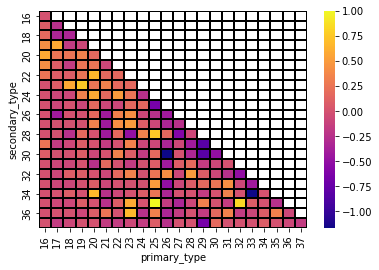

In [25]:
sns.heatmap(pd_diffprim,annot=False,linewidths=0.1,linecolor='black', cmap="plasma")
pd_diffprim.mean(axis = 0, skipna = True).mean()

-0.01884935215791182

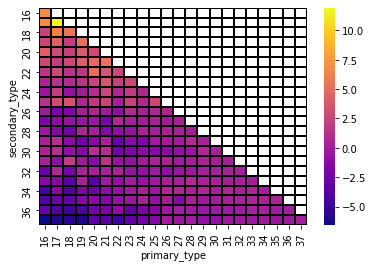

In [26]:
sns.heatmap(pd_diffseco,annot=False,linewidths=0.1,linecolor='black', cmap="plasma")
pd_diffseco.mean(axis = 0, skipna = True).mean()

0.5754570128614008

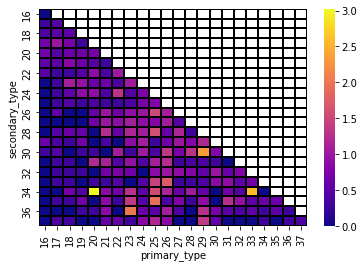

In [27]:
sns.heatmap(pd_stdprim,annot=False,linewidths=0.1,linecolor='black', cmap="plasma")
pd_stdprim.mean(axis = 0, skipna = True).mean()

2.0585904898200904

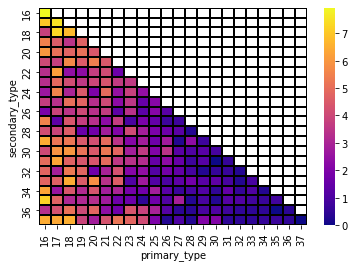

In [28]:
sns.heatmap(pd_stdseco,annot=False,linewidths=0.1,linecolor='black', cmap="plasma")
pd_stdseco.mean(axis = 0, skipna = True).mean()

Text(0.5, 1.0, 'chi-quare')

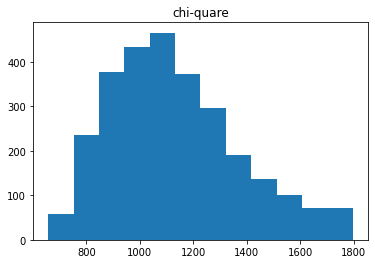

In [29]:
restricted_list = [x for x in chilist if 0 <= x <= 1800]
fig, axe = plt.subplots()
axe.hist(restricted_list,bins=12)
plt.title('chi-quare')

Text(0.5, 1.0, 'chi-quare')

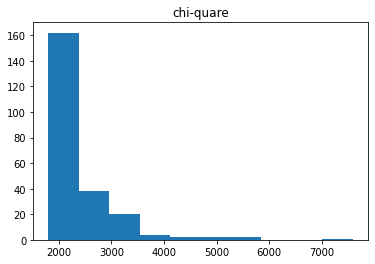

In [37]:
restricted_list = [x for x in chilist if 1800 < x <= 12000]
fig, axe = plt.subplots()
axe.hist(restricted_list,bins=10)
plt.title('chi-quare')

In [31]:
len(chilist)

3036

In [32]:
max(chilist)

7586.938686926273

In [33]:
min(chilist)

657.344963589298

In [34]:
np.mean(chilist)

1223.0181186150862